In [1]:
# For google colab
# ! pip install deeppavlov
# ! pip install pybind11

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from math import ceil, floor
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from typing import *
import copy
import sys
from deeppavlov.dataset_readers.ontonotes_reader import OntonotesReader

2018-09-10 18:30:34.403 DEBUG in 'matplotlib.backends'['__init__'] at line 90: backend module://ipykernel.pylab.backend_inline version unknown


In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
TRAIN_ELMO = False
TRAIN_ALL_ELMO_PARAMS = False
MULTICLASS = False
USE_BIO_MARKUP = False
N_EXAMPLES = 20

In [5]:
def read_data():
    reader = OntonotesReader()
    dataset = reader.read(data_path='data/')
    # print(dataset.keys())
    print('Num of train sentences: {}'.format(len(dataset['train'])))
    print('Num of valid sentences: {}'.format(len(dataset['valid'])))
    print('Num of test sentences: {}'.format(len(dataset['test'])))
    print(dataset['train'][50:60])
    return dataset

def filter_data_by_ne_type(data:list, ne_types:list, tags2binary=False, preserveBIO=False, keepIfAny=True):
    if ne_types == None or len(ne_types) == 0:
        return data
    data_filtered = []
    for tokens,tags in data:
        contains_all = True
        contains_any = False
        tags_norm = [getNeTagMainPart(t) for t in tags]
        for ne_type in ne_types:
            if not ne_type in tags_norm:
                contains_all = False
            if ne_type in tags_norm:
                contains_any = True
        if contains_all or (keepIfAny and contains_any):
            if tags2binary:
                if preserveBIO:
                    tags = [tags[i][:2]+'T' if t in ne_types else 'O' for i,t in enumerate(tags_norm)]
                else:
                    tags = ['T' if t in ne_types else 'O' for t in tags_norm]
            else:
                if preserveBIO:
                    tags = [tags[i][:2]+t if t in ne_types else 'O' for i,t in enumerate(tags_norm)]
                else:
                    tags = [t if t in ne_types else 'O' for i,t in enumerate(tags_norm)]
            data_filtered.append((tokens,tags))
    return data_filtered

def filter_dataset_by_ne_types(dataset: list, ne_types, tags2binary=True, preserveBIO=False, keepIfAny=True):
    dataset = copy.deepcopy(dataset)
    if not isinstance(ne_types, list):
        ne_types = [ne_types]
    for dataset_type in ['train', 'valid', 'test']:
        dataset[dataset_type] = filter_data_by_ne_type(dataset[dataset_type], ne_types, tags2binary=tags2binary, preserveBIO=preserveBIO)
        print('Num of {} sentences: {}'.format(dataset_type, len(dataset[dataset_type])))
    return dataset

def get_data_sample(data, n_samples: int):
    indices = np.random.choice(len(data), size=n_samples, replace=False)
    return split_tokens_tags([data[i] for i in indices])

def get_tokens_len(tokens):
    if isinstance(tokens[0], str):
        tokens = [tokens]
    return [len(seq) for seq in tokens]

def to_lower_case(tokens:list):
    tokens_lower = []
    for seq in tokens:
        tokens_lower.append([])
        for token in seq:
            tokens_lower[-1].append(token.lower())
    return tokens_lower

def add_padding(tokens:list):
    if isinstance(tokens[0], str):
        return tokens, len(tokens)
    elif isinstance(tokens[0], list):
        tokens = copy.deepcopy(tokens)
        max_len = 0
        for seq in tokens:
            if len(seq) > max_len:
                max_len = len(seq)
        for seq in tokens:
            i = len(seq)
            while i < max_len:
                seq.append('')
                i += 1
        return tokens
    else:
        raise Exception('tokens should be either list of strings or list of lists of strings')
  
def getNeTagMainPart(tag:str):
    return tag[2:] if len(tag) > 2 else tag

def tags2binaryFlat(tags):
    return np.array([1 if t == 'T' or (len(t) > 2 and t[2:] == 'T') else 0 for seq in tags for t in seq])

def tagsEncodePadded(tags:list, binary=True, tag2idx=None):
#     if tag2idx:
#         binary = False
    if isinstance(tags[0], str):
        tags = [tags]
    n_sentences = len(tags)
    tokens_length = get_tokens_len(tags)
    max_len = np.max(tokens_length)
    y = np.zeros((n_sentences, max_len))
    for i, sen in enumerate(tags):
        for j, tag in enumerate(sen):
            if binary: 
                y[i][j] = 1 if tags[i][j] != 'O' else 0
            else:
                if tag2idx:
#                     tag_name = tag if USE_BIO_MARKUP else getNeTagMainPart(tag)
                    tag_name = tag   # in case when BIO markup was deleted from data
                    y[i][j] = tag2idx[tag_name]
                else:
                    raise Exception('tag2idx dictionary should be provided')
    return y

def get_matrices(tokens, tags, embedder):
    return (embeddings2feat_mat(embedder.embed(tokens), get_tokens_len(tokens)),
           tags2binaryFlat(tags))
  
def split_tokens_tags(dataset: list):
    tokens = []
    tags = []
    for sample in dataset:
        tokens.append(sample[0])
        tags.append(sample[1])
    return tokens, tags

def count_tags(dataset: list):
    tag_counts = {}
    for data_type in ['train', 'valid', 'test']:
        tag_counts[data_type] = {}
        for sen in dataset[data_type]:
            tags = sen[1]
            for tag in tags:
                if tag_counts[data_type].get(tag):
                    tag_counts[data_type][tag] += 1
                else:
                    tag_counts[data_type][tag] = 1
    return tag_counts

In [6]:
dataset_orig = read_data()
ne_types = ['PERSON']
print('NE types used for training:')
print(ne_types)
print('{} in total'.format(len(ne_types)))
dataset = filter_dataset_by_ne_types(dataset_orig, ne_types, tags2binary=not MULTICLASS, preserveBIO=USE_BIO_MARKUP, keepIfAny=True)
print('Number of sentences in filtered dataset: train: {}, valid: {}, test: {}'.format(len(dataset['train']), len(dataset['valid']), len(dataset['test'])))
tag_counts = count_tags(dataset)
print('Tag counts:')
print(tag_counts)

Num of train sentences: 75187
Num of valid sentences: 9603
Num of test sentences: 9479
[(['Actions', 'had', 'to', 'be', 'taken', 'to', 'break', 'through', 'the', 'blockade', '.'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']), (['On', 'a', 'night', 'in', 'late', 'July', '1940', ',', 'the', 'atmosphere', 'in', 'Zhuanbi', 'Village', 'in', 'Shaanxi', 'was', 'unusual', '.'], ['O', 'B-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'B-GPE', 'I-GPE', 'O', 'B-GPE', 'O', 'O', 'O']), (['Villager', 'Xiao', 'Jianghe', 'has', 'a', 'vivid', 'memory', 'of', 'this', 'piece', 'of', 'history', '.'], ['O', 'B-PERSON', 'I-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']), (['On', 'that', 'dark', 'night', ',', 'everyone', 'was', 'sleeping', 'when', 'human', 'voices', 'and', 'neighing', 'horses', 'were', 'heard', 'within', 'the', 'village', '.'], ['O', 'B-TIME', 'I-TIME', 'I-TIME', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '

In [7]:
# print(dataset['train'][:10])

In [8]:
indices = np.random.choice(len(dataset['train']), size=N_EXAMPLES, replace=False)
train_sen_count = floor(N_EXAMPLES/2)
valid_sen_count = N_EXAMPLES - train_sen_count
support_set = [dataset['train'][i] for i in indices[:train_sen_count]]
valid_set = [dataset['train'][i] for i in indices[train_sen_count:]]
print('Support set:')
print(support_set)
print('Valid set:')
print(valid_set)

Support set:
[(['Considering', 'that', 'Gao', 'fled', 'a', 'tyrannical', 'government', 'to', 'become', 'an', 'expatriate', ',', 'many', 'people', 'wonder', 'whether', 'Gao', "'s", 'literature', 'insists', 'upon', 'humanitarianism', 'and', 'high', 'principles', '.'], ['O', 'O', 'T', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'T', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']), (['and', 'she', 'said', 'Alison', 'she', 'said', 'I', 'just', 'felt', 'real', 'strong', 'I', 'needed', 'to', 'call', 'and', 'tell', 'you', 'that', 'God', "'s", 'taking', 'you', 'to', 'your', 'promised', 'land'], ['O', 'O', 'O', 'T', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']), (['Chiewpy', ',', 'France', "'s", 'Minister', 'of', 'Foreign', 'Affairs', ',', 'also', 'expressed', 'clearly', 'last', 'week', 'that', ',', '"', 'the', 'prerequisites', 'for', '"', 'lifting', 'the', 'embargo', '"', 'are', 'that', 'France', 'withdraws

In [9]:
tag2idx = {}
idx2tag = []
tag2idx['O'] = 0
idx2tag.append('O')
i = 1
for tag in ne_types:
    if USE_BIO_MARKUP:
        tag2idx['B-'+tag] = i
        tag2idx['I-'+tag] = i+1
        idx2tag.append('B-'+tag)
        idx2tag.append('I-'+tag)
        i += 2
    else:
        tag2idx[tag] = i
        idx2tag.append(tag)
        i += 1
print(tag2idx)
print(idx2tag)

{'O': 0, 'PERSON': 1}
['O', 'PERSON']


In [10]:
from deeppavlov.core.common.check_gpu import GPU_AVAILABLE
INITIALIZER = tf.contrib.layers.xavier_initializer

def cudnn_lstm_wrapper(units, n_hidden, n_layers=1, trainable_initial_states=None, seq_lengths=None, initial_h=None,
                       initial_c=None, name='cudnn_lstm', reuse=False):

    if GPU_AVAILABLE:
        return cudnn_lstm(units, n_hidden, n_layers, trainable_initial_states,
                          seq_lengths, initial_h, initial_c, name, reuse)

    log.info('\nWarning! tf.contrib.cudnn_rnn.CudnnCompatibleLSTMCell is used. '
             'It is okay for inference mode, but '
             'if you train your model with this cell it could NOT be used with '
             'tf.contrib.cudnn_rnn.CudnnLSTMCell later. '
             )

    return cudnn_compatible_lstm(units, n_hidden, n_layers, trainable_initial_states,
                                 seq_lengths, initial_h, initial_c, name, reuse)

def cudnn_lstm(units, n_hidden, n_layers=1, trainable_initial_states=None, seq_lengths=None, initial_h=None,
               initial_c=None, name='cudnn_lstm', reuse=False):
    """ Fast CuDNN LSTM implementation

        Args:
            units: tf.Tensor with dimensions [B x T x F], where
                B - batch size
                T - number of tokens
                F - features
            n_hidden: dimensionality of hidden state
            n_layers: number of layers
            trainable_initial_states: whether to create a special trainable variable
                to initialize the hidden states of the network or use just zeros
            seq_lengths: tensor of sequence lengths with dimension [B]
            initial_h: optional initial hidden state, masks trainable_initial_states
                if provided
            initial_c: optional initial cell state, masks trainable_initial_states
                if provided
            name: name of the variable scope to use
            reuse:whether to reuse already initialized variable


        Returns:
            h - all hidden states along T dimension,
                tf.Tensor with dimensionality [B x T x F]
            h_last - last hidden state, tf.Tensor with dimensionality [B x (n_layers * H)]
                where H - number of hidden units
            c_last - last cell state, tf.Tensor with dimensionality [B x (n_layers * H)]
                where H - number of hidden units
        """
    with tf.variable_scope(name, reuse=reuse):
        lstm = tf.contrib.cudnn_rnn.CudnnLSTM(num_layers=n_layers,
                                              num_units=n_hidden)
        if trainable_initial_states:
            init_h = tf.get_variable('init_h', [n_layers, 1, n_hidden])
            init_h = tf.tile(init_h, (1, tf.shape(units)[0], 1))
            init_c = tf.get_variable('init_c', [n_layers, 1, n_hidden])
            init_c = tf.tile(init_c, (1, tf.shape(units)[0], 1))
        else:
            init_h = init_c = tf.zeros([n_layers, tf.shape(units)[0], n_hidden])

        initial_h = initial_h or init_h
        initial_c = initial_c or init_c

        h, (h_last, c_last) = lstm(tf.transpose(units, (1, 0, 2)), (initial_h, initial_c))
        h = tf.transpose(h, (1, 0, 2))
        h_last = tf.reshape(h_last, shape=(-1, n_hidden))
        c_last = tf.reshape(c_last, shape=(-1, n_hidden))

        # Extract last states if they are provided
        if seq_lengths is not None:
            indices = tf.stack([tf.range(tf.shape(h)[0]), seq_lengths], axis=1)
            h_last = tf.gather_nd(h, indices)

        return h, (h_last, c_last)

def cudnn_bi_lstm(units,
                  n_hidden,
                  seq_lengths=None,
                  n_layers=1,
                  trainable_initial_states=False,
                  name='cudnn_bi_lstm',
                  reuse=False):
    """ Fast CuDNN Bi-LSTM implementation

        Args:
            units: tf.Tensor with dimensions [B x T x F], where
                B - batch size
                T - number of tokens
                F - features
            n_hidden: dimensionality of hidden state
            seq_lengths: number of tokens in each sample in the batch
            n_layers: number of layers
            trainable_initial_states: whether to create a special trainable variable
                to initialize the hidden states of the network or use just zeros
            name: name of the variable scope to use
            reuse:whether to reuse already initialized variable

        Returns:
            h - all hidden states along T dimension,
                tf.Tensor with dimensionality [B x T x F]
            h_last - last hidden state, tf.Tensor with dimensionality [B x H * 2]
                where H - number of hidden units
            c_last - last cell state, tf.Tensor with dimensionality [B x H * 2]
                where H - number of hidden units
        """
    with tf.variable_scope(name, reuse=reuse):
        if seq_lengths is None:
            seq_lengths = tf.ones([tf.shape(units)[0]], dtype=tf.int32) * tf.shape(units)[1]
        with tf.variable_scope('Forward'):
            h_fw, (h_fw_last, c_fw_last) = cudnn_lstm_wrapper(units,
                                                              n_hidden,
                                                              n_layers=n_layers,
                                                              trainable_initial_states=trainable_initial_states,
                                                              seq_lengths=seq_lengths)

        with tf.variable_scope('Backward'):
            reversed_units = tf.reverse_sequence(units, seq_lengths=seq_lengths, seq_dim=1, batch_dim=0)
            h_bw, (h_bw_last, c_bw_last) = cudnn_lstm_wrapper(reversed_units,
                                                              n_hidden,
                                                              n_layers=n_layers,
                                                              trainable_initial_states=trainable_initial_states,
                                                              seq_lengths=seq_lengths)

            h_bw = tf.reverse_sequence(h_bw, seq_lengths=seq_lengths, seq_dim=1, batch_dim=0)
        return (h_fw, h_bw), ((h_fw_last, c_fw_last), (h_bw_last, c_bw_last))

def bi_rnn(units: tf.Tensor,
           n_hidden: List,
           cell_type='gru',
           seq_lengths=None,
           trainable_initial_states=False,
           use_peepholes=False,
           name='Bi-'):
    """ Bi directional recurrent neural network. GRU or LSTM

        Args:
            units: a tensorflow tensor with dimensionality [None, n_tokens, n_features]
            n_hidden_list: list with number of hidden units at the ouput of each layer
            seq_lengths: length of sequences for different length sequences in batch
                can be None for maximum length as a length for every sample in the batch
            cell_type: 'lstm' or 'gru'
            trainable_initial_states: whether to create a special trainable variable
                to initialize the hidden states of the network or use just zeros
            use_peepholes: whether to use peephole connections (only 'lstm' case affected)
            name: what variable_scope to use for the network parameters
            add_l2_losses: whether to add l2 losses on network kernels to
                tf.GraphKeys.REGULARIZATION_LOSSES or not
        Returns:
            units: tensor at the output of the last recurrent layer
                with dimensionality [None, n_tokens, n_hidden_list[-1]]
            last_units: tensor of last hidden states for GRU and tuple
                of last hidden stated and last cell states for LSTM
                dimensionality of cell states and hidden states are
                similar and equal to [B x 2 * H], where B - batch
                size and H is number of hidden units
    """

    with tf.variable_scope(name + '_' + cell_type.upper()):
        if cell_type == 'gru':
            forward_cell = tf.nn.rnn_cell.GRUCell(n_hidden, kernel_initializer=INITIALIZER())
            backward_cell = tf.nn.rnn_cell.GRUCell(n_hidden, kernel_initializer=INITIALIZER())
            if trainable_initial_states:
                initial_state_fw = tf.tile(tf.get_variable('init_fw_h', [1, n_hidden]), (tf.shape(units)[0], 1))
                initial_state_bw = tf.tile(tf.get_variable('init_bw_h', [1, n_hidden]), (tf.shape(units)[0], 1))
            else:
                initial_state_fw = initial_state_bw = None
        elif cell_type == 'lstm':
            forward_cell = tf.nn.rnn_cell.LSTMCell(n_hidden, use_peepholes=use_peepholes, initializer=INITIALIZER())
            backward_cell = tf.nn.rnn_cell.LSTMCell(n_hidden, use_peepholes=use_peepholes, initializer=INITIALIZER())
            if trainable_initial_states:
                initial_state_fw = tf.nn.rnn_cell.LSTMStateTuple(
                    tf.tile(tf.get_variable('init_fw_c', [1, n_hidden]), (tf.shape(units)[0], 1)),
                    tf.tile(tf.get_variable('init_fw_h', [1, n_hidden]), (tf.shape(units)[0], 1)))
                initial_state_bw = tf.nn.rnn_cell.LSTMStateTuple(
                    tf.tile(tf.get_variable('init_bw_c', [1, n_hidden]), (tf.shape(units)[0], 1)),
                    tf.tile(tf.get_variable('init_bw_h', [1, n_hidden]), (tf.shape(units)[0], 1)))
            else:
                initial_state_fw = initial_state_bw = None
        else:
            raise RuntimeError('cell_type must be either "gru" or "lstm"s')
        (rnn_output_fw, rnn_output_bw), (fw, bw) = \
            tf.nn.bidirectional_dynamic_rnn(forward_cell,
                                            backward_cell,
                                            units,
                                            dtype=tf.float32,
                                            sequence_length=seq_lengths,
                                            initial_state_fw=initial_state_fw,
                                            initial_state_bw=initial_state_bw)
    kernels = [var for var in forward_cell.trainable_variables +
               backward_cell.trainable_variables if 'kernel' in var.name]
    for kernel in kernels:
        tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, tf.nn.l2_loss(kernel))
    return (rnn_output_fw, rnn_output_bw), (fw, bw)

def build_cudnn_rnn(units, mask, n_hidden_list:Tuple[int]=(128,), cell_type:str='lstm', intra_layer_dropout:bool=False, dropout_ph=None):
    sequence_lengths = tf.to_int32(tf.reduce_sum(mask, axis=1))
    for n, n_hidden in enumerate(n_hidden_list):
        with tf.variable_scope(cell_type.upper() + '_' + str(n)):
            if cell_type.lower() == 'lstm':
                units, _ = cudnn_bi_lstm(units, n_hidden, sequence_lengths)
            elif cell_type.lower() == 'gru':
                units, _ = cudnn_bi_gru(units, n_hidden, sequence_lengths)
            else:
                raise RuntimeError('Wrong cell type "{}"! Only "gru" and "lstm"!'.format(cell_type))
            units = tf.concat(units, -1)
            if intra_layer_dropout and n != len(n_hidden_list) - 1:
                units = variational_dropout(units, dropout_ph)
    return units

def build_rnn(units, n_hidden_list:Tuple[int]=(128,), cell_type:str='lstm', intra_layer_dropout:bool=False, dropout_ph=None):
    for n, n_hidden in enumerate(n_hidden_list):
        units, _ = bi_rnn(units, n_hidden, cell_type=cell_type, name='Layer_' + str(n))
        units = tf.concat(units, -1)
        if intra_layer_dropout and n != len(n_hidden_list) - 1:
            units = variational_dropout(units, dropout_ph)
    return units

def build_top(units, n_tags=18*2+1, top_dropout:bool=False, two_dense_on_top:bool=False, n_hidden=128):
    if top_dropout:
        units = variational_dropout(units, dropout_ph)
    if two_dense_on_top:
        units = tf.layers.dense(units, n_hidden, activation=tf.nn.relu,
                                kernel_initializer=INITIALIZER(),
                                kernel_regularizer=tf.nn.l2_loss)
    logits = tf.layers.dense(units, n_tags, activation=None,
                             kernel_initializer=INITIALIZER(),
                             kernel_regularizer=tf.nn.l2_loss)
    return logits

def build_train_predict(logits, n_tags, mask, y_ph, use_crf, learning_rate_ph, clip_grad_norm, l2_reg):
    res = {}
    if use_crf:
        sequence_lengths = tf.reduce_sum(mask, axis=1)
        log_likelihood, transition_params = tf.contrib.crf.crf_log_likelihood(logits, y_ph, sequence_lengths)
        loss_tensor = -log_likelihood
        res['transition_params'] = transition_params
    else:
        ground_truth_labels = tf.one_hot(y_ph, n_tags)
        loss_tensor = tf.nn.softmax_cross_entropy_with_logits(labels=ground_truth_labels, logits=logits)
        loss_tensor = loss_tensor * mask
        y_pred = tf.argmax(logits, axis=-1)
        res['y_pred'] = y_pred

    loss = tf.reduce_mean(loss_tensor)

    # L2 regularization
    if l2_reg > 0:
        loss += l2_reg * tf.reduce_sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
    res['loss'] = loss
        
    # optimizer = partial(tf.train.MomentumOptimizer, momentum=0.9, use_nesterov=True)
    optimizer = tf.train.AdamOptimizer
    train_op = get_train_op(loss, learning_rate_ph, optimizer, clip_norm=clip_grad_norm)
    res['train_op'] = train_op
    return res

def predict_no_crf(y_pred, mask_ph, feed_dict):
    pred_idxs, mask = sess.run([y_pred, mask_ph], feed_dict)

    # Filter by sequece length
    sequence_lengths = np.sum(mask, axis=1).astype(np.int32)
    pred = []
    for utt, l in zip(pred_idxs, sequence_lengths):
        pred.append(utt[:l])
    return pred

def predict_crf(logits, transition_params, mask_ph, feed_dict):
    logits, trans_params, mask = sess.run([logits,
                                           transition_params,
                                           mask_ph],
                                           feed_dict=feed_dict)
    sequence_lengths = np.maximum(np.sum(mask, axis=1).astype(np.int32), 1)
    # iterate over the sentences because no batching in viterbi_decode
    pred = []
    for logit, sequence_length in zip(logits, sequence_lengths):
        logit = logit[:int(sequence_length)]  # keep only the valid steps
        viterbi_seq, viterbi_score = tf.contrib.crf.viterbi_decode(logit, trans_params)
        pred += [viterbi_seq]
    return pred

def get_train_op(loss,
                 learning_rate,
                 optimizer=None,
                 clip_norm=None,
                 learnable_scopes=None,
                 optimizer_scope_name=None,
                 trainable_vars:list=None):
    """ Get train operation for given loss

    Args:
        loss: loss, tf tensor or scalar
        learning_rate: scalar or placeholder
        clip_norm: clip gradients norm by clip_norm
        learnable_scopes: which scopes are trainable (None for all)
        optimizer: instance of tf.train.Optimizer, default Adam

    Returns:
        train_op
    """
    if optimizer_scope_name is None:
        opt_scope = tf.variable_scope('Optimizer')
    else:
        opt_scope = tf.variable_scope(optimizer_scope_name)
    with opt_scope:
        if learnable_scopes is None:
            variables_to_train = tf.global_variables()
        else:
            variables_to_train = []
            for scope_name in learnable_scopes:
                for var in tf.global_variables():
                    if scope_name in var.name:
                        variables_to_train.append(var)
        if trainable_vars:
            variables_to_train = trainable_vars
            
        if optimizer is None:
            optimizer = tf.train.AdamOptimizer

        # For batch norm it is necessary to update running averages
        extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(extra_update_ops):
            opt = optimizer(learning_rate)
            grads_and_vars = opt.compute_gradients(loss, var_list=variables_to_train)
            if clip_norm is not None:
                grads_and_vars = [(tf.clip_by_norm(grad, clip_norm), var)
                                  for grad, var in grads_and_vars] #  if grad is not None
            train_op = opt.apply_gradients(grads_and_vars)
    return train_op

In [11]:
# def get_batch(dataset, batch_size=None, binaryTags=True, tag2idx=None):
#     if not batch_size:
#         batch_size = len(dataset)
#     indices = np.arange(len(dataset))
#     np.random.shuffle(indices)
#     tokens_train, tags_train = split_tokens_tags([dataset[i] for i in indices[:batch_size]])
#     mask_train = make_mask(tokens_train)
#     tokens_train = add_padding(tokens_train)
#     y_train = tagsEncodePadded(tags_train, binary=binaryTags, tag2idx=tag2idx)
    
#     tokens_valid, tags_valid = split_tokens_tags([dataset[i] for i in indices[batch_size:]])
#     mask_valid = make_mask(tokens_valid)
#     tokens_valid = add_padding(tokens_valid)
#     y_valid = tagsEncodePadded(tags_valid, binary=binaryTags, tag2idx=tag2idx)
    
#     return ((tokens_train, tags_train, mask_train, y_train), (tokens_valid, tags_valid, mask_valid, y_valid))

def get_batch(dataset, batch_size=None, binaryTags=True, tag2idx=None):
    if not batch_size:
        batch_size = len(dataset)
    tokens, tags = get_data_sample(dataset, batch_size)
    mask = make_mask(tokens)
    tokens_length = get_tokens_len(tokens)
    tokens = add_padding(tokens)
    y = tagsEncodePadded(tags, binary=binaryTags, tag2idx=tag2idx)
    return tokens, tags, mask, y

def make_mask(seq_list):
  seq_count = len(seq_list)
  seq_length = [len(s) for s in seq_list]
  max_len = np.max(seq_length)
  mask = np.zeros((seq_count, max_len), dtype=int)
  seq_length = np.tile(np.expand_dims(seq_length, axis=-1), (1, max_len))
  range_ar = np.tile(np.arange(1, max_len+1, 1), (seq_count, 1))
  mask[range_ar <= seq_length] = 1
  return mask

def flatten_with_mask(seq_mat, mask):
  return seq_mat[mask == 1]

def concatenate_arrays(ar_list):
  return np.concatenate(ar_list)

In [12]:
class DatasetIterator:
    def __init__(self, data):
        self.data = {
            'train': data['train'],
            'valid': data['valid'],
            'test': data['test']
        }
        
    def get_samples_count(self, data_type='train'):
        return len(self.data[data_type])

    def gen_batches(self, batch_size, data_type='train', shuffle=True, binaryTags=False, tag2idx=None):
        indices = np.arange(len(self.data[data_type]))
        if shuffle:
            np.random.shuffle(indices)
        n = indices.size
        k = 0
        while k < n:
            top = k + batch_size
            if top > n: 
                top = n
            indices_batch = indices[k:top]
            tokens,tags = split_tokens_tags([self.data[data_type][i] for i in indices_batch])
            mask = make_mask(tokens)
            tokens_length = get_tokens_len(tokens)
            tokens = add_padding(tokens)
            y = tagsEncodePadded(tags, binary=binaryTags, tag2idx=tag2idx)
            yield tokens, tags, mask, y
            k += batch_size

In [13]:
def eval_dataset(batch_generator, tag2idx, data_type='valid'):
    pred_total = []
    true_total = []
    loss_valid_total = 0
    for i, (tokens_valid, tags_valid, mask_valid, y_valid) in enumerate(batch_generator.gen_batches(32, data_type=data_type, shuffle=False, binaryTags=not MULTICLASS, tag2idx=tag2idx)):
        feed_valid = fill_feed_dict({tokens_input_ph: tokens_valid, mask_ph: mask_valid, y_ph: y_valid, training_ph: False}, train=False)
        y_valid_flat = flatten_with_mask(y_valid, mask_valid)
        loss_valid = sess.run([loss], feed_dict=feed_valid)[0]
        if use_crf:
            pred = predict_crf(logits, transition_params, mask_ph, feed_dict=feed_valid)
        else:
            pred = predict_no_crf(y_pred, mask_ph, feed_dict=feed_valid)
        pred = concatenate_arrays(pred)
        loss_valid_total += loss_valid
        pred_total = np.concatenate([pred_total, pred])
        true_total = np.concatenate([true_total, y_valid_flat])
    n_tags = len(tag2idx.keys())
    f1_valid = f1_score(true_total, pred_total, average=None, labels=list(range(1,n_tags)))
    loss_valid_total = loss_valid_total/(i+1)
    
    return {'loss': loss_valid_total, 'f1': f1_valid}

In [14]:
def eval_valid(batch_generator, tag2idx):
    pred_total = []
    true_total = []
    loss_valid_total = 0
    for i, (tokens_valid, tags_valid, mask_valid, y_valid) in enumerate(batch_generator.gen_batches(32, data_type='valid', shuffle=False, binaryTags=False, tag2idx=tag2idx)):
        feed_valid = fill_feed_dict({tokens_input_ph: tokens_valid, mask_ph: mask_valid, y_ph: y_valid, training_ph: False}, train=False)
        y_valid_flat = flatten_with_mask(y_valid, mask_valid)
        loss_valid = sess.run([loss], feed_dict=feed_valid)[0]
        if use_crf:
            pred = predict_crf(logits, transition_params, mask_ph, feed_dict=feed_valid)
        else:
            pred = predict_no_crf(y_pred, mask_ph, feed_dict=feed_valid)
#         print('y_true: {}'.format(y_valid))
#         print('y_pred: {}'.format(pred))
        pred = concatenate_arrays(pred)
        loss_valid_total += loss_valid
        pred_total = np.concatenate([pred_total, pred])
        true_total = np.concatenate([true_total, y_valid_flat])
#     print(np.unique(true_total))
#     print(np.unique(pred_total))
#     print(true_total.size == pred_total.size)
#     a = np.arange(true_total.size)
#     print(a[true_total == 2])
#     print(a[pred_total == 2])
    n_tags = len(tag2idx.keys())
    f1_valid = f1_score(true_total, pred_total, average=None, labels=list(range(1,n_tags)))
#     print(f1_valid)
    loss_valid_total = loss_valid_total/(i+1)
    
    return {'loss': loss_valid_total, 'f1': f1_valid}

In [15]:
tf.reset_default_graph()
sess = tf.Session()

In [16]:
elmo = hub.Module("https://tfhub.dev/google/elmo/1", trainable=TRAIN_ELMO)

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.


2018-09-10 18:30:39.999 INFO in 'tensorflow'['tf_logging'] at line 159: Using /tmp/tfhub_modules to cache modules.


In [17]:
print(tf.trainable_variables())
elmo_vars = []
if TRAIN_ELMO:
    elmo_coef = {'layer_coefficients': tf.trainable_variables()[-2], 'scaling': tf.trainable_variables()[-1]}
    print(elmo_coef)
    elmo_vars = tf.trainable_variables()
    elmo_vars_coef = list(elmo_coef.values())
    elmo_vars_cell_weights = [v for v in elmo_vars if v not in elmo_vars_coef]
    vars_dict = {v.name:v for v in tf.trainable_variables()}
if TRAIN_ALL_ELMO_PARAMS:
    cell0_kernel = vars_dict['module/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0']
    cell1_kernel = vars_dict['module/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel:0']

[]


In [18]:
# Configuration
use_cudnn_rnn = True
l2_reg = 0
n_hidden_list = (128,)
cell_type = 'lstm'
n_tags = len(idx2tag)
use_crf = True
clip_grad_norm = 5.0
learning_rate = 1e-3
lr_decay = 0.5
lr_min = 1e-5
dropout_keep_prob = 1
batch_size = 3

### Build computational graph

In [19]:
# Placeholders
tokens_input_ph = tf.placeholder(shape=[None, None], dtype=tf.string)
# tokens_length_ph = tf.placeholder(shape=[None], dtype=tf.int32)
mask_ph = tf.placeholder(tf.float32, [None, None], name='Mask_ph')
y_ph = tf.placeholder(shape=[None, None], dtype=tf.int32, name='y_ph')
learning_rate_ph = tf.placeholder_with_default(learning_rate, shape=[], name='learning_rate')
dropout_ph = tf.placeholder_with_default(dropout_keep_prob, shape=[], name='dropout')
training_ph = tf.placeholder_with_default(False, shape=[], name='is_training')

In [20]:
def fill_feed_dict(inp: dict, train=True):
    feed_dict = {learning_rate_ph: learning_rate, dropout_ph: dropout_keep_prob if train else 1.0, training_ph: train}
    feed_dict.update(inp)
    return feed_dict

In [21]:
y_pred = None
transition_params = None
tokens_length = tf.to_int32(tf.reduce_sum(mask_ph, axis=1))
emb = elmo(inputs={"tokens": tokens_input_ph,
                    "sequence_len": tokens_length},
                  signature="tokens",
                  as_dict=True)['elmo']
# mask = tf.sequence_mask(lengths=tokens_length_ph, dtype=tf.float32)
features = emb
if use_cudnn_rnn:
    units = build_cudnn_rnn(features, mask_ph, n_hidden_list, cell_type)
else:
    units = build_rnn(features, n_hidden_list, cell_type)

logits = build_top(units, n_tags=n_tags)

out_dict = build_train_predict(logits, n_tags, mask_ph, y_ph, use_crf, learning_rate_ph, clip_grad_norm, l2_reg)
train_op_all = out_dict['train_op']
loss = out_dict['loss']
if use_crf:
    transition_params = out_dict['transition_params']
else:
    y_pred = out_dict['y_pred']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-09-10 18:30:40.701 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


Instructions for updating:
seq_dim is deprecated, use seq_axis instead


2018-09-10 18:30:40.837 WARNING in 'tensorflow'['tf_logging'] at line 125: From <ipython-input-10-43f176f69ae1>:117: calling reverse_sequence (from tensorflow.python.ops.array_ops) with seq_dim is deprecated and will be removed in a future version.
Instructions for updating:
seq_dim is deprecated, use seq_axis instead


Instructions for updating:
batch_dim is deprecated, use batch_axis instead


2018-09-10 18:30:40.860 WARNING in 'tensorflow'['tf_logging'] at line 125: From /home/clement/virtenv/env/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py:454: calling reverse_sequence (from tensorflow.python.ops.array_ops) with batch_dim is deprecated and will be removed in a future version.
Instructions for updating:
batch_dim is deprecated, use batch_axis instead
/home/clement/virtenv/env/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [22]:
all_vars = tf.trainable_variables()
model_vars = [v for v in all_vars if v not in elmo_vars]
print(model_vars)
vars_dict = {v.name:v for v in tf.trainable_variables()}

[<tf.Variable 'LSTM_0/cudnn_bi_lstm/Forward/cudnn_lstm/cudnn_lstm/opaque_kernel:0' shape=<unknown> dtype=float32_ref>, <tf.Variable 'LSTM_0/cudnn_bi_lstm/Backward/cudnn_lstm/cudnn_lstm/opaque_kernel:0' shape=<unknown> dtype=float32_ref>, <tf.Variable 'dense/kernel:0' shape=(256, 2) dtype=float32_ref>, <tf.Variable 'dense/bias:0' shape=(2,) dtype=float32_ref>, <tf.Variable 'transitions:0' shape=(2, 2) dtype=float32_ref>]


In [23]:
# Optimizers for different parameters
with tf.variable_scope('Optimizer', reuse=tf.AUTO_REUSE):
    train_op_model = get_train_op(loss, learning_rate_ph, tf.train.AdamOptimizer, clip_norm=clip_grad_norm, trainable_vars=model_vars)
    if TRAIN_ELMO:
        train_op_elmo = get_train_op(loss, learning_rate_ph, tf.train.AdamOptimizer, clip_norm=clip_grad_norm, trainable_vars=elmo_vars)
        train_op_elmo_coef = get_train_op(loss, learning_rate_ph, tf.train.AdamOptimizer, clip_norm=clip_grad_norm, trainable_vars=elmo_vars_coef)
        train_op_elmo_cell_weights = get_train_op(loss, learning_rate_ph, tf.train.AdamOptimizer, clip_norm=clip_grad_norm, trainable_vars=elmo_vars_cell_weights)

/home/clement/virtenv/env/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [24]:
file_writer = tf.summary.FileWriter('./graph/bilstm_crf_elmo_bio_multi', tf.get_default_graph())

### Train model

In [25]:
variables = tf.trainable_variables()
vars_dict = {v.name: v for v in variables}
saver = tf.train.Saver(vars_dict)
MODEL_SAVE_PATH = "./model_params/lstm_fewshot.ckpt"

In [26]:
initialize_op = tf.global_variables_initializer()
sess.run([initialize_op])

[None]

In [27]:
dataset_iterator = DatasetIterator(dataset)

In [37]:
tokens_valid, tags_valid, mask_valid, y_valid = get_batch(valid_set, None, binaryTags=not MULTICLASS, tag2idx=tag2idx)
feed_valid = fill_feed_dict({tokens_input_ph: tokens_valid, mask_ph: mask_valid, y_ph: y_valid, training_ph: False}, train=False)
y_valid_flat = flatten_with_mask(y_valid, mask_valid)
print(tokens_valid)
print(tags_valid)
print(len)

[['Here', "'s", 'the', 'difference', 'between', 'Bush', 'and', 'Gore', 'when', 'it', 'comes', 'to', 'corporate', 'power', '.', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''], ['According', 'to', 'a', 'detailed', 'report', 'by', 'Zbigniew', 'Bochniarz', 'of', 'the', 'University', 'of', 'Minnesota', "'s", 'Hubert', 'Humphrey', 'Institute', ',', '27', 'areas', 'containing', 'a', 'third', 'of', 'Poland', "'s", 'population', 'are', 'regarded', 'as', '``', 'ecological', 'hazards', "''", 'due', 'to', 'multiple', 'violations', 'of', 'standards', '.', '', '', '', '', '', '', ''], ['-LSB-', 'Board', 'of', 'Supervisors', 'Chairman', 'Chris', '-RSB-', 'Zimmerman', 'and', 'others', 'speaking', 'yesterday', 'said', 'that', 'the', 'vounty', 'sees', 'the', 'empty', 'space', 'as', 'an', 'opportunity', 'to', '``', 'reimagine', "''", 'and', '``', 'brand', "''", 'Crystal', 'City', 'as', 'an', 'attractive', 'destination', 

In [29]:
tag2idx

{'O': 0, 'PERSON': 1}

In [30]:
training_schedule = [{'train_op': train_op_model, 'n_steps': 100, 'lr': 1e-3}]

In [31]:
num_steps = 100
patience_limit = 10
patience = 0
num_steps = np.sum([s['n_steps'] for s in training_schedule])
stage = 0
n_steps_prev_stages = 0
display_step = 5
valid_step = 10
losses = {'train': [], 'valid': []}
f1_scores = {'train': [], 'valid': []}
best_valid_f1 = 0
d_elmo_cells_list = {'cell0':[], 'cell1':[]}
learning_rate = training_schedule[stage]['lr']
train_op = training_schedule[stage]['train_op']
print('Model saving path: {}'.format(MODEL_SAVE_PATH))
for step in range(1, num_steps+1):
    print('Step {}/{}'.format(step, num_steps))
    if step > n_steps_prev_stages + training_schedule[stage]['n_steps']:
        print('Moving to the next stage')
        n_steps_prev_stages += training_schedule[stage]['n_steps']
        stage += 1
        learning_rate = training_schedule[stage]['lr']
        train_op = training_schedule[stage]['train_op']
    tokens_batch, tags_batch, mask_batch, y_batch = get_batch(support_set, batch_size)
    feed = fill_feed_dict({tokens_input_ph: tokens_batch, mask_ph: mask_batch, y_ph: y_batch, learning_rate_ph: learning_rate})
    if TRAIN_ALL_ELMO_PARAMS:
        cell0_kernel_val1 = cell0_kernel.eval(session=sess)
        cell1_kernel_val1 = cell1_kernel.eval(session=sess)
    # Train
    with tf.variable_scope('', reuse=tf.AUTO_REUSE):
        loss_cur, _ = sess.run([loss, train_op], feed_dict=feed)
    losses['train'].append(loss_cur)
    if TRAIN_ALL_ELMO_PARAMS:
        cell0_kernel_val2 = cell0_kernel.eval(session=sess)
        cell1_kernel_val2 = cell1_kernel.eval(session=sess)
        d_cell0_kernel = np.linalg.norm(cell0_kernel_val2 - cell0_kernel_val1)/np.linalg.norm(cell0_kernel_val1)
        d_cell1_kernel = np.linalg.norm(cell1_kernel_val2 - cell1_kernel_val1)/np.linalg.norm(cell1_kernel_val1)
        d_elmo_cells_list['cell0'].append(d_cell0_kernel)
        d_elmo_cells_list['cell1'].append(d_cell1_kernel)
    # Validate
    with tf.variable_scope('', reuse=tf.AUTO_REUSE):
        loss_valid = sess.run([loss], feed_dict=feed_valid)[0]
        losses['valid'].append(loss_valid)
        if use_crf:
            pred = predict_crf(logits, transition_params, mask_ph, feed_dict=feed_valid)
        else:
            pred = predict_no_crf(y_pred, mask_ph, feed_dict=feed_valid)
        f1_valid = f1_score(flatten_with_mask(y_valid, mask_valid), concatenate_arrays(pred))
#         res = eval_dataset(dataset_iterator, tag2idx, data_type='valid')
#         f1_valid = res['f1']
#         loss_valid = res['loss']
        if isinstance(f1_valid, list) or isinstance(f1_valid, np.ndarray):
            f1_valid = np.mean(f1_valid)
        f1_scores['valid'].append(f1_valid)
        if f1_valid > best_valid_f1:
            best_valid_f1 = f1_valid
            save_path = saver.save(sess, MODEL_SAVE_PATH)
            print("Model saved.")
        else:
            patience += 1
            if patience > patience_limit:
                print('Running out of patience')
                patience = 0
                learning_rate *= lr_decay
                print('New learning rate: {}'.format(learning_rate))
                if learning_rate < lr_min:
                    print('Learning rate below limit. Stop training.')
                    break
                print('Restoring best model ...')
                saver.restore(sess, MODEL_SAVE_PATH)
    # Get elmo params
    with tf.variable_scope('', reuse=tf.AUTO_REUSE):
        if TRAIN_ELMO:
            layer_coeff, scale = sess.run([elmo_coef['layer_coefficients'], elmo_coef['scaling']])
            if f1_valid == best_valid_f1:
                elmo_params_best = {'layer_coefficients': layer_coeff, 'scaling': scale}
    if step % display_step == 0 or step == 1:
        print('Train loss = {}'.format(losses['train'][-1]))
        if TRAIN_ELMO:
            with tf.variable_scope('', reuse=tf.AUTO_REUSE):
                print('ELMo weights:')
                print('Coefficients = {}, scale = {}'.format(layer_coeff, scale))
        if TRAIN_ALL_ELMO_PARAMS:
            print('ELMo cells change per step: cell0: {:.2f}%, cell1: {:.2f}%'.format(d_cell0_kernel*100, d_cell1_kernel*100))
        
    if step % valid_step == 0 or step == 1:
        print('Valid loss = {}'.format(losses['valid'][-1]))
        print('Valid F1 score = {}'.format(f1_scores['valid'][-1]))

Model saving path: ./model_params/lstm_fewshot.ckpt
Step 1/100
Model saved.
Train loss = 25.65250587463379
Valid loss = 24.66534996032715
Valid F1 score = 0.11486486486486486
Step 2/100
Step 3/100
Step 4/100


/home/clement/virtenv/env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Step 5/100
Train loss = 4.470335960388184
Step 6/100
Step 7/100
Step 8/100
Model saved.
Step 9/100
Model saved.
Step 10/100
Model saved.
Train loss = 1.4181360006332397
Valid loss = 3.3976149559020996
Valid F1 score = 0.7058823529411765
Step 11/100
Model saved.
Step 12/100
Step 13/100
Step 14/100
Step 15/100
Train loss = 0.6080315709114075
Step 16/100
Running out of patience
New learning rate: 0.0005
Restoring best model ...
INFO:tensorflow:Restoring parameters from ./model_params/lstm_fewshot.ckpt


2018-09-10 18:30:58.467 INFO in 'tensorflow'['tf_logging'] at line 115: Restoring parameters from ./model_params/lstm_fewshot.ckpt


Step 17/100
Step 18/100
Step 19/100
Step 20/100
Train loss = 1.0069618225097656
Valid loss = 2.565377712249756
Valid F1 score = 0.7428571428571428
Step 21/100
Model saved.
Step 22/100
Step 23/100
Step 24/100
Step 25/100
Train loss = 0.28436151146888733
Step 26/100
Step 27/100
Step 28/100
Running out of patience
New learning rate: 0.00025
Restoring best model ...
INFO:tensorflow:Restoring parameters from ./model_params/lstm_fewshot.ckpt


2018-09-10 18:31:03.407 INFO in 'tensorflow'['tf_logging'] at line 115: Restoring parameters from ./model_params/lstm_fewshot.ckpt


Step 29/100
Model saved.
Step 30/100
Train loss = 0.49649491906166077
Valid loss = 2.3288092613220215
Valid F1 score = 0.7407407407407407
Step 31/100
Step 32/100
Step 33/100
Step 34/100
Step 35/100
Train loss = 0.40121904015541077
Step 36/100
Step 37/100
Step 38/100
Step 39/100
Step 40/100
Running out of patience
New learning rate: 0.000125
Restoring best model ...
INFO:tensorflow:Restoring parameters from ./model_params/lstm_fewshot.ckpt


2018-09-10 18:31:08.766 INFO in 'tensorflow'['tf_logging'] at line 115: Restoring parameters from ./model_params/lstm_fewshot.ckpt


Train loss = 0.6032584309577942
Valid loss = 2.010068416595459
Valid F1 score = 0.7407407407407407
Step 41/100
Step 42/100
Step 43/100
Step 44/100
Step 45/100
Train loss = 0.38099098205566406
Step 46/100
Step 47/100
Step 48/100
Step 49/100
Step 50/100
Train loss = 0.3883148729801178
Valid loss = 2.187182903289795
Valid F1 score = 0.7407407407407407
Step 51/100
Running out of patience
New learning rate: 6.25e-05
Restoring best model ...
INFO:tensorflow:Restoring parameters from ./model_params/lstm_fewshot.ckpt


2018-09-10 18:31:13.488 INFO in 'tensorflow'['tf_logging'] at line 115: Restoring parameters from ./model_params/lstm_fewshot.ckpt


Step 52/100
Step 53/100
Step 54/100
Step 55/100
Train loss = 0.4715353548526764
Step 56/100
Step 57/100
Step 58/100
Step 59/100
Step 60/100
Train loss = 0.6947228312492371
Valid loss = 2.2722971439361572
Valid F1 score = 0.7407407407407407
Step 61/100
Step 62/100
Running out of patience
New learning rate: 3.125e-05
Restoring best model ...
INFO:tensorflow:Restoring parameters from ./model_params/lstm_fewshot.ckpt


2018-09-10 18:31:18.352 INFO in 'tensorflow'['tf_logging'] at line 115: Restoring parameters from ./model_params/lstm_fewshot.ckpt


Step 63/100
Step 64/100
Step 65/100
Train loss = 0.7419493794441223
Step 66/100
Step 67/100
Step 68/100
Step 69/100
Step 70/100
Train loss = 0.6391718983650208
Valid loss = 2.3220596313476562
Valid F1 score = 0.7407407407407407
Step 71/100
Step 72/100
Step 73/100
Running out of patience
New learning rate: 1.5625e-05
Restoring best model ...
INFO:tensorflow:Restoring parameters from ./model_params/lstm_fewshot.ckpt


2018-09-10 18:31:23.903 INFO in 'tensorflow'['tf_logging'] at line 115: Restoring parameters from ./model_params/lstm_fewshot.ckpt


Step 74/100
Step 75/100
Train loss = 0.5274060368537903
Step 76/100
Step 77/100
Step 78/100
Step 79/100
Step 80/100
Train loss = 0.3956778943538666
Valid loss = 2.352055072784424
Valid F1 score = 0.7407407407407407
Step 81/100
Step 82/100
Step 83/100
Step 84/100
Running out of patience
New learning rate: 7.8125e-06
Learning rate below limit. Stop training.


2018-09-10 18:31:29.386 DEBUG in 'matplotlib.font_manager'['font_manager'] at line 1346: findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/clement/virtenv/env/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
2018-09-10 18:31:29.429 DEBUG in 'matplotlib.font_manager'['font_manager'] at line 1346: findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/home/clement/virtenv/env/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


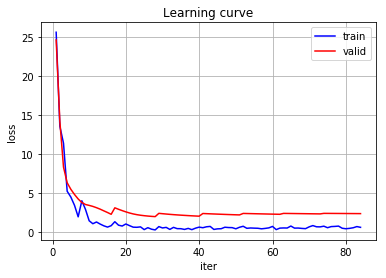

In [32]:
# Plot learning curve
num_steps = len(losses['train'])
plt.figure()
steps = np.arange(1, num_steps+1, 1)
plt.plot(steps, losses['train'], c='b', label='train')
plt.plot(steps, losses['valid'], c='r', label='valid')
plt.xlabel('iter')
plt.ylabel('loss')
plt.legend()
plt.title('Learning curve')
plt.grid()

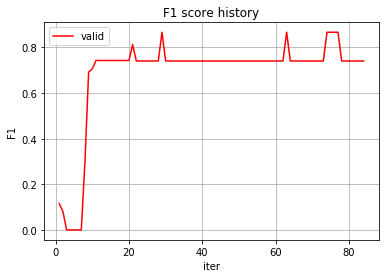

In [33]:
# Plot F1 scores
plt.figure()
steps = np.arange(1, num_steps+1, 1)
# plt.plot(steps, losses['train'], c='b', label='train')
plt.plot(steps, f1_scores['valid'], c='r', label='valid')
plt.xlabel('iter')
plt.ylabel('F1')
plt.legend()
plt.title('F1 score history')
plt.grid()

In [34]:
print('Best F1 score on validation: {:.2f}'.format(best_valid_f1*100))
if TRAIN_ELMO:
    layer_coeff, scale = sess.run([elmo_coef['layer_coefficients'], elmo_coef['scaling']])
    elmo_params = {'layer_coefficients': layer_coeff, 'scaling': scale}
    elmo_layer_coeff = np.exp(elmo_params['layer_coefficients'])*elmo_params['scaling']
    print('Learned ELMo layer combination weights:')
    print(elmo_layer_coeff)
    print('Normalized:')
    print(np.exp(elmo_layer_coeff)/np.sum(np.exp(elmo_layer_coeff)))

Best F1 score on validation: 86.67


### Restore best model

In [35]:
saver.restore(sess, MODEL_SAVE_PATH)

INFO:tensorflow:Restoring parameters from ./model_params/lstm_fewshot.ckpt


2018-09-10 18:31:29.612 INFO in 'tensorflow'['tf_logging'] at line 115: Restoring parameters from ./model_params/lstm_fewshot.ckpt


### Evaluate on test dataset

In [36]:
res = eval_dataset(dataset_iterator, tag2idx, data_type='test')
f1_test = res['f1'][0]
loss_test = res['loss']
print('Test loss = {:.4f}'.format(loss_test))
print('Test F1 score = {:.2f}'.format(f1_test*100))

Test loss = 2.6316
Test F1 score = 70.07
